### Processing Data

In [1]:
import numpy as np
import pandas as pd

import lightgbm as lgb

from sklearn.feature_selection import VarianceThreshold

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import time

In [2]:
train_datapath_2016 = "./zillow data/merged_2016 v2.csv"
train_datapath_2017 = "./zillow data/merged_2017 v2.csv"

test_datapath_2016 = "./zillow data/properties_2016 v2.csv"
test_datapath_2017 = "./zillow data/properties_2017 v2.csv"

In [3]:
# modify 'transactiondate' of df to keep only the month
def parse_transactiondate(df):
    # modify transactiondate col to keep only the month
    new_transactiondate = []
    for data in df['transactiondate']:
        temp = data.split("-")
        new_transactiondate.append(int(temp[1])) # keep only month

    new_transactiondate = np.array(new_transactiondate)
    new_transactiondate = new_transactiondate.reshape(new_transactiondate.shape[0], 1)

    df['transactiondate'] = new_transactiondate

# return label index, feature index list
# assumes that df label_is_first
def split_on_label(df):
    return df.columns[0], df.columns[1:]

def gen_testdata(df, new_transactiondate):
    df_copy = df.copy()
    # df_copy['transactiondate'] = new_transactiondate
    df_copy.insert(0, 'transactiondate', new_transactiondate)
    return df_copy

def get_low_var_feature(support_list):
    low_var_feature_index = []
    support_feature_index = []
    for i in range(len(support_list)):
        if support_list[i]:
            support_feature_index.append(i)
        else:
            low_var_feature_index.append(i)
    return low_var_feature_index, support_feature_index

def handle_low_var(sel, train_data, feature_list):
    temp_sel = sel.fit(train_data)
    low_var_list, support_list = get_low_var_feature(sel.get_support())
    exclude_low_var_name = []
    for i in low_var_list:
        exclude_low_var_name.append(train_data.columns.values[i])

    return low_var_list,exclude_low_var_name

def removing_missing(X_train, missing_threshold = 0.95):
    exclude_missing = []
    num_rows = X_train.shape[0]
    for col in X_train.columns:
        num_missing = X_train[col].isna().sum()
        if num_missing == 0:
            continue
        missing_fraction = num_missing/float(num_rows)
        if missing_fraction > missing_threshold:
            exclude_missing.append(col)
            
    return exclude_missing

# removing features with unique value
def removing_unique(X_train):
    exclude_unique = []
    for col in X_train.columns:
        num_unique = len(X_train[col].unique())
        if X_train[col].isna().sum()!=0 and num_unique == 1:
            exclude_unique.append(col)
            
    return exclude_unique

def print_list(li,list_name = ''):
    print('%s (%d) :' %(list_name,len(li)))
    for i in li:
        print(i)
        
def get_train_features(X_train,el1 = [], el2 = [], el3 = [],el4 = []):
    train_feature = []
    for col in X_train:
        if col not in el1 and col not in el2 and col not in el3 and col not in el4:
            train_feature.append(col)
    return train_feature

# geting categorical features
def get_cat_feature(X_train, cat_threshold):
    cat_feature_inds = []
    cat_feature = []
    for i,col in enumerate(X_train):
        num_uniques = len(X_train[col].unique())
        if num_uniques < cat_threshold and not 'sqft' in col and not 'cnt' in col \
        and not 'nbr' in col and not 'number' in col:
            cat_feature_inds.append(i)
            cat_feature.append(col)
    return cat_feature_inds,cat_feature

In [4]:
train_data2016 = pd.read_csv(train_datapath_2016, index_col=0)
train_data2017 = pd.read_csv(train_datapath_2017, index_col=0)

# --- TEMP Fixes for train_data2016 (not well formatted) ---
# fix Unamed: 0 at col index 3
fix_col = train_data2016.columns.str.contains('unnamed',case = False)
train_data2016 = train_data2016.drop(train_data2016.columns[fix_col], axis=1)
# --- END ---

parcelid16 = train_data2016['parcelid']
parcelid17 = train_data2017['parcelid']

# drop parcelid (index of properties features)
train_data2016 = train_data2016.drop('parcelid', axis=1)
train_data2017 = train_data2017.drop('parcelid', axis=1)

label16, feature16 = split_on_label(train_data2016)
label17, feature17 = split_on_label(train_data2017)

print("[2016] num of features:", len(feature16))
print("[2016] num of instances:", train_data2016.shape[0])

print("[2017] num of features:", len(feature17))
print("[2017] num of instances:", train_data2017.shape[0])

# modify 'transactiondate' to keep only the month
parse_transactiondate(train_data2016)
parse_transactiondate(train_data2017)

# training data and label for model 2016
X_train16 = train_data2016[feature16]
y_train16 = train_data2016[label16]

# training data and label for model 2017
X_train17 = train_data2017[feature17]
y_train17 = train_data2017[label17]

[2016] num of features: 58
[2016] num of instances: 90275
[2017] num of features: 58
[2017] num of instances: 77613


In [5]:
import gc
del train_data2016,train_data2017
gc.collect()

44

In [6]:
# Removing Freatures with too many missing data
exclude_missing16 = removing_missing(X_train16)
exclude_missing17 = removing_missing(X_train17)

# Removing Features with unique values
exclude_unique16 = removing_unique(X_train16)
exclude_unique17 = removing_unique(X_train17)

# Removing Features with low variance
# it should remove features with many missing values that were filled by imputation
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))

_, exclude_low_var16 = handle_low_var(sel, X_train16, feature16)
_, exclude_low_var17 = handle_low_var(sel, X_train17, feature17)

In [7]:
print_list(exclude_missing16,'exclude_missing16')
print_list(exclude_low_var16,'exclude_low_var16')
print_list(exclude_unique16,'exclude_unique16')
print_list(exclude_missing17,'exclude_missing17')
print_list(exclude_low_var17,'exclude_low_var17')
print_list(exclude_unique17,'exclude_unique17')

exclude_missing16 (0) :
exclude_low_var16 (16) :
architecturalstyletypeid
buildingclasstypeid
decktypeid
fireplacecnt
hashottuborspa
poolcnt
pooltypeid10
pooltypeid2
pooltypeid7
storytypeid
threequarterbathnbr
typeconstructiontypeid
numberofstories
fireplaceflag
assessmentyear
taxdelinquencyflag
exclude_unique16 (0) :
exclude_missing17 (0) :
exclude_low_var17 (16) :
architecturalstyletypeid
buildingclasstypeid
decktypeid
fireplacecnt
hashottuborspa
poolcnt
pooltypeid10
pooltypeid2
pooltypeid7
storytypeid
threequarterbathnbr
typeconstructiontypeid
numberofstories
fireplaceflag
assessmentyear
taxdelinquencyflag
exclude_unique17 (0) :


In [8]:
train_feature16 = get_train_features(X_train16, el1 = exclude_missing16, 
                                                el2 = exclude_low_var16,
                                                el3 = exclude_unique16)

new_X_train16 = X_train16[train_feature16]

print("\n[2016] num of features:", new_X_train16.shape[1])
print_list(train_feature16,"train_feature16")


[2016] num of features: 42
train_feature16 (42) :
transactiondate
airconditioningtypeid
basementsqft
bathroomcnt
bedroomcnt
buildingqualitytypeid
calculatedbathnbr
finishedfloor1squarefeet
calculatedfinishedsquarefeet
finishedsquarefeet12
finishedsquarefeet13
finishedsquarefeet15
finishedsquarefeet50
finishedsquarefeet6
fips
fullbathcnt
garagecarcnt
garagetotalsqft
heatingorsystemtypeid
latitude
longitude
lotsizesquarefeet
poolsizesum
propertycountylandusecode
propertylandusetypeid
propertyzoningdesc
rawcensustractandblock
regionidcity
regionidcounty
regionidneighborhood
regionidzip
roomcnt
unitcnt
yardbuildingsqft17
yardbuildingsqft26
yearbuilt
structuretaxvaluedollarcnt
taxvaluedollarcnt
landtaxvaluedollarcnt
taxamount
taxdelinquencyyear
censustractandblock


In [9]:
train_feature17 = get_train_features(X_train16, el1 = exclude_missing17, 
                                                el2 = exclude_low_var17,
                                                el3 = exclude_unique17)

new_X_train17 = X_train17[train_feature17]

print("\n[2017] num of features:", new_X_train17.shape[1])
print_list(train_feature16,"train_feature17")


[2017] num of features: 42
train_feature17 (42) :
transactiondate
airconditioningtypeid
basementsqft
bathroomcnt
bedroomcnt
buildingqualitytypeid
calculatedbathnbr
finishedfloor1squarefeet
calculatedfinishedsquarefeet
finishedsquarefeet12
finishedsquarefeet13
finishedsquarefeet15
finishedsquarefeet50
finishedsquarefeet6
fips
fullbathcnt
garagecarcnt
garagetotalsqft
heatingorsystemtypeid
latitude
longitude
lotsizesquarefeet
poolsizesum
propertycountylandusecode
propertylandusetypeid
propertyzoningdesc
rawcensustractandblock
regionidcity
regionidcounty
regionidneighborhood
regionidzip
roomcnt
unitcnt
yardbuildingsqft17
yardbuildingsqft26
yearbuilt
structuretaxvaluedollarcnt
taxvaluedollarcnt
landtaxvaluedollarcnt
taxamount
taxdelinquencyyear
censustractandblock


In [10]:
# read in test
test_data2016 = pd.read_csv(test_datapath_2016, index_col=0)
test_data2017 = pd.read_csv(test_datapath_2017, index_col=0)

print("[2016] num of instances: ", test_data2016.shape[0])
print("[2017] num of instances: ", test_data2017.shape[0])

# save parcelid for merge 
test_parcelid16 = test_data2016['parcelid']
test_parcelid17 = test_data2017['parcelid']

# drop parcelid col
test_data2016 = test_data2016.drop('parcelid', axis=1)
test_data2017 = test_data2017.drop('parcelid', axis=1)

# generate transaction date
test10_16 = np.repeat(10, test_data2016.shape[0])
test11_16 = np.repeat(11, test_data2016.shape[0])
test12_16 = np.repeat(12, test_data2016.shape[0])

test10_17 = np.repeat(10, test_data2017.shape[0])
test11_17 = np.repeat(11, test_data2017.shape[0])
test12_17 = np.repeat(12, test_data2017.shape[0])

# get new test data with transaction date
X_test10_16 = gen_testdata(test_data2016, test10_16)
X_test11_16 = gen_testdata(test_data2016, test11_16)
X_test12_16 = gen_testdata(test_data2016, test12_16)

X_test10_17 = gen_testdata(test_data2017, test10_17)
X_test11_17 = gen_testdata(test_data2017, test11_17)
X_test12_17 = gen_testdata(test_data2017, test12_17)

del test_data2016,test_datapath_2017
gc.collect()

/Users/apple/venv/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


[2016] num of instances:  2985217
[2017] num of instances:  2985217


70

### LightGBM

### Feauture Selection

In [186]:
def handle_lightGBM_RFECV(X_train, y_train):
    
    params = {"learning_rate":0.015,
              #'n_estimators':100,
              #'num_leaves':100,
              #'reg_alpha':0.01,
              #'reg_lambda':0.01,
              #'min_split_gain':0.1,
              #'min_child_samples':100,
              #'subsample':1.0,
              #'subsample_for_bin':50000
             }
    bst = lgb.LGBMRegressor(n_jobs = -1, random_state = 42,silent = False,
                            learning_rate = params['learning_rate'],
                            #n_estimators = params['n_estimators'],
                            #num_leaves = params['num_leaves'],
                            #reg_alpha = params['reg_alpha'],
                            #reg_lambda = params['reg_lambda'],
                            #min_split_gain = params['min_split_gain'],
                            #min_child_samples = params['min_child_samples'],
                            #subsample = params['subsample'],
                            #subsample_for_bin = params['subsample_for_bin'],
                           )
    # cross-validate on num of features selected using RFECV
    # step parameter is number of features to remove at each step
    selector = RFECV(bst, step=1, cv=5)
    # selector = RFE(bst, 7, step=5)
    selector = selector.fit(X_train, y_train)
        
    # selected feature index
    feature = []
    for j in range(len(selector.support_)):
        if selector.support_[j]:
            feature.append(j)

    print("size of opt_feature from CV:", selector.n_features_)

    # obtain train MAE with CV'ed alpha value
    bst = lgb.LGBMRegressor(n_jobs = -1, random_state = 42,silent = False,
                            learning_rate = params['learning_rate'],
                            #n_estimators = params['n_estimators'],
                            #num_leaves = params['num_leaves'],
                            #reg_alpha = params['reg_alpha'],
                            #reg_lambda = params['reg_lambda'],
                            #min_split_gain = params['min_split_gain'],
                            #min_child_samples = params['min_child_samples'],
                            #subsample = params['subsample'],
                            #subsample_for_bin = params['subsample_for_bin']
                           )
    #bst.fit(X_train[:,feature], y_train)
    #y_pred = bst.predict(X_train[:,feature])
    #print("Train MAE: {:.6}".format(mean_absolute_error(y_train, y_pred)))
    
    return bst,feature,selector

In [187]:
start_time = time.time()

print("RFECV Model 2016:")
bst16, opt_feature, selector = handle_lightGBM_RFECV(X_train17, y_train17)

elapsed_time = time.time() - start_time
print(time.strftime("Elasped time: %H:%M:%S", time.gmtime(elapsed_time)))

RFECV Model 2016:
size of opt_feature from CV: 8
Elasped time: 00:09:19


In [51]:
bst16.fit(X_train16.iloc[:,opt_feature], y_train16)
y_pred = bst16.predict(X_train16.iloc[:,opt_feature])
print("Train MAE: {:.6}".format(mean_absolute_error(y_train16, y_pred)))

Train MAE: 0.067816


In [188]:
X_train17_rfe = X_train17.iloc[:,opt_feature]
X_train17_rfe.columns

Index(['finishedsquarefeet12', 'latitude', 'longitude', 'lotsizesquarefeet',
       'regionidzip', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxamount'],
      dtype='object')

In [189]:
selector.support_

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,  True, False, False,  True, False, False, False,
        True, False, False, False])

### Tunig Parameters

In [16]:
def handle_lightgbm_GridCV(X, y, param_dict):
    
    # cross-validate on alpha (regularization strenght) from alphalist
    
    gbm = lgb.LGBMRegressor(n_jobs = -1, random_state = 42,silent = False)
       
    # cross-validate on random search CV
    grid_search = GridSearchCV(gbm,param_grid=param_dict,
                               cv=5, scoring='neg_mean_absolute_error')
    
    start = time.time()
    grid_search.fit(X, y)
    print("GridSearchCV took %.2f seconds"
          " parameter settings." % (time.time() - start))

    return grid_search

In [18]:
params_dict = {
    'boosting_type':['gbdt'],
    "learning_rate":[0.011],
    'num_leaves':[145],
    'max_depth':[-1],
    'reg_alpha':[0.01],
    'reg_lambda':[100],
    'min_split_gain':[0],
    'min_child_samples':[300],
    'colsample_bytree':[0.8],
    
    #'drop_rate':[0.1],
    #'max_drop':[50],
    #'drop_seed':[4],
    
    'min_child_weight':[0.001],
    'subsample':[0.8],
    'subsample_for_bin':[50000],
    'subsample_freq':[1], 
    'n_eatimators':[512],
    'random_state':[42]
}
grid_result = handle_lightgbm_GridCV(new_X_train16, y_train16, params_dict)
grid_result.grid_scores_

GridSearchCV took 35.74 seconds parameter settings.


/Users/apple/venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.06793, std: 0.00292, params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.011, 'max_depth': -1, 'min_child_samples': 300, 'min_child_weight': 0.001, 'min_split_gain': 0, 'n_eatimators': 512, 'num_leaves': 145, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 100, 'subsample': 0.8, 'subsample_for_bin': 50000, 'subsample_freq': 1}]

### Experiment

In [11]:
dtrain16 = lgb.Dataset(new_X_train16, label=y_train16,free_raw_data=False) 
dtrain17 = lgb.Dataset(new_X_train17, label=y_train17,free_raw_data=False) 
dtrain16 = dtrain16.construct()
dtrain17 = dtrain17.construct()
print(dtrain17.num_feature())
print(dtrain17.num_data())

42
77613


In [20]:
from sklearn.externals import joblib
ransac16 = joblib.load('./model/ransac16-ridge 42.m')
ransac17 = joblib.load('./model/ransac17-ridge 42.m')
inlier_mask16 = ransac16.inlier_mask_
inlier_mask17 = ransac17.inlier_mask_
outlier_mask16 = np.logical_not(inlier_mask16)
outlier_mask17 = np.logical_not(inlier_mask17)
ransac_X_train16 = X_train16[inlier_mask16]
ransac_X_train17 = X_train17[inlier_mask17]
ransac_y_train16 = y_train16[inlier_mask16]
ransac_y_train17 = y_train17[inlier_mask17]

ransac_dtrain16 = lgb.Dataset(ransac_X_train16, label=ransac_y_train16,free_raw_data=False) 
ransac_dtrain17 = lgb.Dataset(ransac_X_train17, label=ransac_y_train17,free_raw_data=False) 
ransac_dtrain16 = ransac_dtrain16.construct()
ransac_dtrain17 = ransac_dtrain17.construct()
print(ransac_dtrain17.num_feature())
print(ransac_dtrain17.num_data())

58
37928


In [ ]:
import warnings
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings('ignore')
def handle_Ransac(X_train, y_train,estimator):
    ransac = linear_model.RANSACRegressor(estimator, max_trials= 10,min_samples = 0.6,random_state = 21)
    ransac.fit(X_train, y_train)
    y_pred = ransac.predict(X_train)
    
    print("MAE: {:.6f}".format(mean_absolute_error(y_train, y_pred)))
    print("R^2: {:.6f}".format(r2_score(y_train, y_pred)))
    
    return ransac
rf = RandomForestRegressor(
                            n_estimators = 100,
                            criterion = 'mae',
                            max_depth = 10
                            )

print("ransac Regression based on Lasso for 2016 train data")
rangbm16 = handle_Ransac(new_X_train16, y_train16, rf)
print("\n")

print("ransac Regression based on Lasso for 2017 train data")
rangbm17 = handle_Ransac(new_X_train17, y_train17, rf)
print("\n")

ransac Regression based on Lasso for 2016 train data


In [120]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(max_samples=100, random_state=21,contamination=0.25)
clf.fit(new_X_train16)
y_pred_inlier16 = clf.predict(new_X_train16)

In [119]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(max_samples=100, random_state=21,contamination=0.25)
clf.fit(new_X_train17)
clf.fit()
y_pred_inlier17 = clf.predict(new_X_train17)

In [128]:
iso_X_train16 = new_X_train16[y_pred_inlier16 != -1]
iso_X_train17 = new_X_train17[y_pred_inlier17 != -1]

In [129]:
iso_y_train16 = y_train16[y_pred_inlier16 != -1]
iso_y_train17 = y_train17[y_pred_inlier17 != -1]

iso_dtrain16 = lgb.Dataset(iso_X_train16, label=iso_y_train16,free_raw_data=False) 
iso_dtrain17 = lgb.Dataset(iso_X_train17, label=iso_y_train17,free_raw_data=False) 
iso_dtrain16 = iso_dtrain16.construct()
iso_dtrain17 = iso_dtrain17.construct()
print(iso_dtrain17.num_feature())
print(iso_dtrain17.num_data())

42
58209


#### Cross_validation

In [143]:
params = {
        'boosting_type': 'gbdt',
        'objective': 'regression l1',
        'metric': 'l1', 
    
        'learning_rate':0.009, 
        'num_leaves': 140, 
        'max_depth': 10, 
        'min_data_in_leaf': 60,
    
        'feature_fraction': 0.8, 
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
    
        'lambda_l1': 0.01,
        'lambda_l2': 10,
        'min_gain_to_split': 0.0,
        'min_sum_hessian_in_leaf': 0.001,
        
        'drop_rate':0.02,
        'max_drop':50,
        'drop_seed':4,
    
        #'verbose': 0,
        #'is_training_metric': 'True'
    }

tuned_param = 'lambda_l2'
param_value_list = [140,150]

for param_value in param_value_list:
    
    params[tuned_param] = param_value
    
    cv_result = lgb.cv(params, iso_dtrain16, stratified=False, nfold = 5, num_boost_round=300, seed = 21,early_stopping_rounds=20)
    
    print('mean: %f, std: %f, params: {%s: %f}'% (min(cv_result['l1-mean']), min(cv_result['l1-stdv']), tuned_param, param_value))

mean: 0.063888, std: 0.000672, params: {lambda_l2: 140.000000}
mean: 0.063887, std: 0.000672, params: {lambda_l2: 150.000000}


#### Model1 Baseline

In [12]:
params = {
        'boosting_type': 'gbdt',  # np.random.choice(['dart', 'gbdt']),
        'objective': 'regression l1',
        'metric': 'l1', 
        'learning_rate':0.011,
        'num_leaves': 145,
        'max_depth': -1,
        'min_data_in_leaf': 300,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'lambda_l1': 0.01,
        'lambda_l2': 100,
        'min_gain_to_split': 0.0,
        'min_sum_hessian_in_leaf': 0.001,
        
        #'drop_rate':0.018,
        #'max_drop':50,
        #'drop_seed':4,
    
        #'verbose': 0,
        #'is_training_metric': 'True'
        }
evals_result0_16 = {}
gbm0_16 = lgb.train(params,dtrain16,num_boost_round=300,
                    valid_sets=[dtrain16],evals_result = evals_result0_16,verbose_eval=True)

[1]	training's l1: 0.068433
[2]	training's l1: 0.0684138
[3]	training's l1: 0.0683905
[4]	training's l1: 0.0683664
[5]	training's l1: 0.0683494
[6]	training's l1: 0.0683278
[7]	training's l1: 0.068306
[8]	training's l1: 0.0682839
[9]	training's l1: 0.0682612
[10]	training's l1: 0.0682402
[11]	training's l1: 0.0682198
[12]	training's l1: 0.0682039
[13]	training's l1: 0.0681846
[14]	training's l1: 0.0681641
[15]	training's l1: 0.0681431
[16]	training's l1: 0.0681225
[17]	training's l1: 0.0681034
[18]	training's l1: 0.0680844
[19]	training's l1: 0.0680666
[20]	training's l1: 0.0680515
[21]	training's l1: 0.0680371
[22]	training's l1: 0.0680193
[23]	training's l1: 0.0680046
[24]	training's l1: 0.0679903
[25]	training's l1: 0.0679728
[26]	training's l1: 0.0679572
[27]	training's l1: 0.0679403
[28]	training's l1: 0.0679263
[29]	training's l1: 0.0679129
[30]	training's l1: 0.0678957
[31]	training's l1: 0.0678816
[32]	training's l1: 0.0678668
[33]	training's l1: 0.0678525
[34]	training's l1: 0

[271]	training's l1: 0.0666106
[272]	training's l1: 0.0666067
[273]	training's l1: 0.0666046
[274]	training's l1: 0.0666038
[275]	training's l1: 0.0666013
[276]	training's l1: 0.0665976
[277]	training's l1: 0.066596
[278]	training's l1: 0.0665921
[279]	training's l1: 0.0665905
[280]	training's l1: 0.0665887
[281]	training's l1: 0.0665869
[282]	training's l1: 0.0665838
[283]	training's l1: 0.06658
[284]	training's l1: 0.0665773
[285]	training's l1: 0.0665755
[286]	training's l1: 0.0665722
[287]	training's l1: 0.0665704
[288]	training's l1: 0.0665666
[289]	training's l1: 0.0665652
[290]	training's l1: 0.0665632
[291]	training's l1: 0.0665595
[292]	training's l1: 0.0665586
[293]	training's l1: 0.0665573
[294]	training's l1: 0.0665539
[295]	training's l1: 0.0665507
[296]	training's l1: 0.066549
[297]	training's l1: 0.0665481
[298]	training's l1: 0.0665453
[299]	training's l1: 0.0665412
[300]	training's l1: 0.0665389


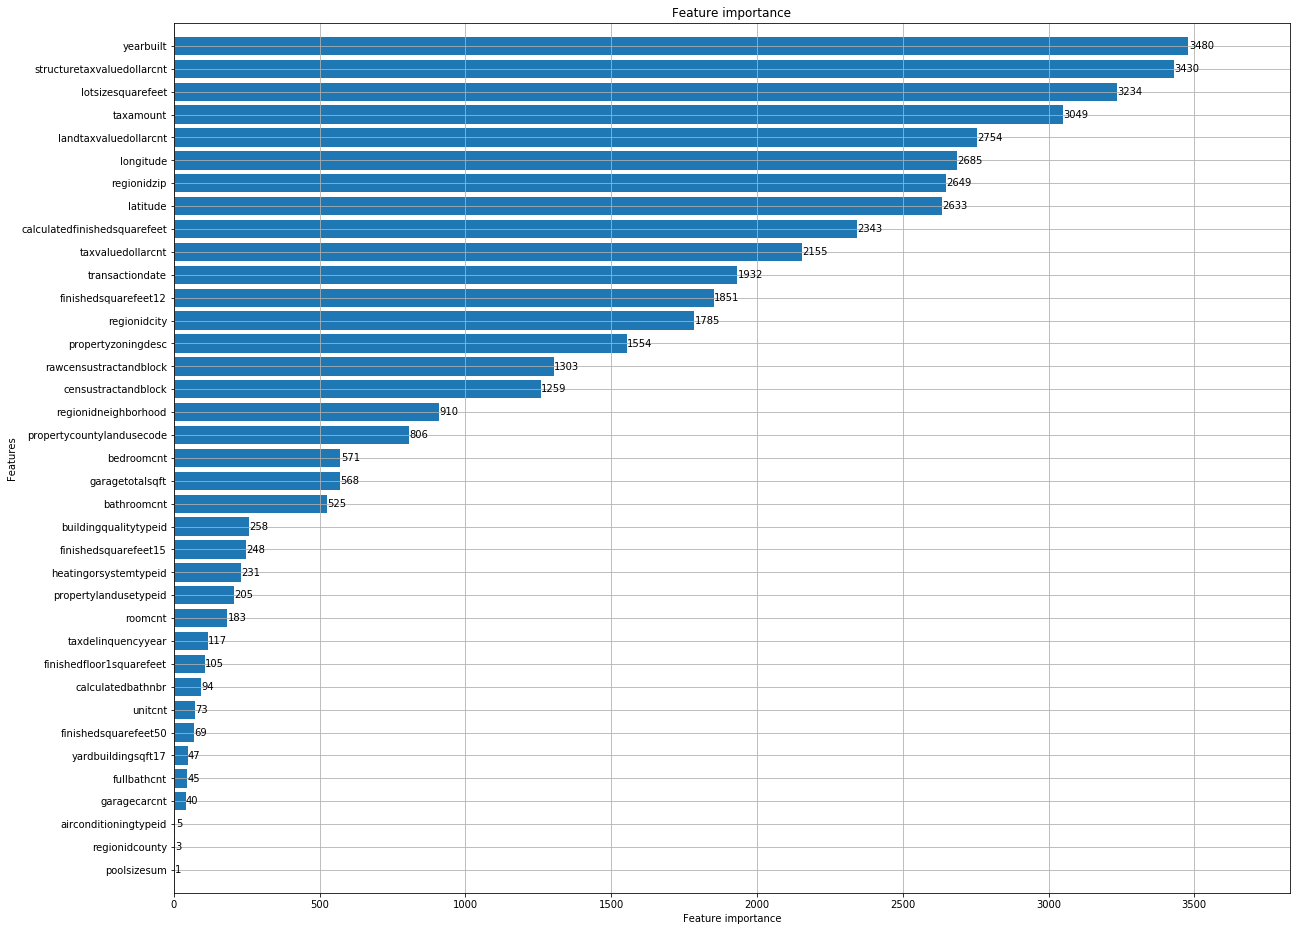

In [73]:
import matplotlib.pyplot as plt
lgb.plot_importance(gbm0_16,figsize=(20,16),height= 0.8)
plt.show()

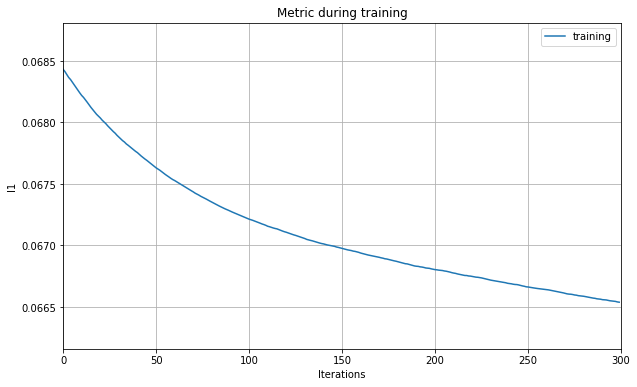

In [82]:
lgb.plot_metric(evals_result0_16,figsize=(10,6))
plt.show()

In [13]:
params = {
        'boosting_type': 'gbdt',  # np.random.choice(['dart', 'gbdt']),
        'objective': 'regression l1',
        'metric': 'l1', 
        'learning_rate':0.011,
        'num_leaves': 80,
        'max_depth': -1,
        'min_data_in_leaf': 300,
        'feature_fraction': 0.6,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'lambda_l1': 0.01,
        'lambda_l2': 500,
        'min_gain_to_split': 0.0,
        'min_sum_hessian_in_leaf': 0.001,
        
        #'drop_rate':0.018,
        #'max_drop':50,
        #'drop_seed':4,
    
        #'verbose': 0,
        #'is_training_metric': 'True'
        }
evals_result0_17 = {}
gbm0_17 = lgb.train(params,dtrain17,num_boost_round=300,
                    valid_sets=[dtrain17],evals_result = evals_result0_17,verbose_eval=True)

[1]	training's l1: 0.0706699
[2]	training's l1: 0.0706571
[3]	training's l1: 0.0706426
[4]	training's l1: 0.0706303
[5]	training's l1: 0.0706158
[6]	training's l1: 0.0706045
[7]	training's l1: 0.0705944
[8]	training's l1: 0.0705814
[9]	training's l1: 0.0705688
[10]	training's l1: 0.0705572
[11]	training's l1: 0.0705448
[12]	training's l1: 0.070531
[13]	training's l1: 0.0705195
[14]	training's l1: 0.0705085
[15]	training's l1: 0.0704985
[16]	training's l1: 0.0704879
[17]	training's l1: 0.0704776
[18]	training's l1: 0.0704662
[19]	training's l1: 0.0704536
[20]	training's l1: 0.0704446
[21]	training's l1: 0.0704353
[22]	training's l1: 0.0704236
[23]	training's l1: 0.0704122
[24]	training's l1: 0.0704026
[25]	training's l1: 0.0703922
[26]	training's l1: 0.0703838
[27]	training's l1: 0.0703751
[28]	training's l1: 0.0703657
[29]	training's l1: 0.0703561
[30]	training's l1: 0.0703469
[31]	training's l1: 0.0703397
[32]	training's l1: 0.0703297
[33]	training's l1: 0.0703207
[34]	training's l1: 

[270]	training's l1: 0.0696037
[271]	training's l1: 0.0696011
[272]	training's l1: 0.0696016
[273]	training's l1: 0.0696014
[274]	training's l1: 0.0696005
[275]	training's l1: 0.0695997
[276]	training's l1: 0.0695966
[277]	training's l1: 0.0695945
[278]	training's l1: 0.069592
[279]	training's l1: 0.0695924
[280]	training's l1: 0.0695918
[281]	training's l1: 0.0695914
[282]	training's l1: 0.0695912
[283]	training's l1: 0.0695894
[284]	training's l1: 0.0695885
[285]	training's l1: 0.069588
[286]	training's l1: 0.0695862
[287]	training's l1: 0.0695838
[288]	training's l1: 0.0695833
[289]	training's l1: 0.0695828
[290]	training's l1: 0.0695813
[291]	training's l1: 0.0695811
[292]	training's l1: 0.0695797
[293]	training's l1: 0.069578
[294]	training's l1: 0.0695762
[295]	training's l1: 0.069576
[296]	training's l1: 0.0695739
[297]	training's l1: 0.0695744
[298]	training's l1: 0.0695732
[299]	training's l1: 0.0695718
[300]	training's l1: 0.0695696


### Dart + LightGBM

#### 2016

In [14]:
params = {
        'boosting_type': 'dart',  # np.random.choice(['dart', 'gbdt']),
        'objective': 'regression l1',
        'metric': 'l1', 
        'learning_rate':0.014,
        'num_leaves': 145,
        'max_depth': -1,
        'min_data_in_leaf': 300,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'lambda_l1': 0.01,
        'lambda_l2': 100,
        'min_gain_to_split': 0.0,
        'min_sum_hessian_in_leaf': 0.001,
        
        'drop_rate':0.02,
        'max_drop':50,
        'drop_seed':4,
    
        #'verbose': 0,
        #'is_training_metric': 'True'
        }
evals_result1_16 = {}
gbm1_16 = lgb.train(params,dtrain16,num_boost_round=300,
                       valid_sets=[dtrain16],evals_result = evals_result1_16,verbose_eval=True)

[1]	training's l1: 0.0684262
[2]	training's l1: 0.0684019
[3]	training's l1: 0.0683728
[4]	training's l1: 0.0683427
[5]	training's l1: 0.0683219
[6]	training's l1: 0.0682963
[7]	training's l1: 0.0682695
[8]	training's l1: 0.0682418
[9]	training's l1: 0.0682151
[10]	training's l1: 0.0681898
[11]	training's l1: 0.0681652
[12]	training's l1: 0.0681459
[13]	training's l1: 0.0681227
[14]	training's l1: 0.0680982
[15]	training's l1: 0.0680735
[16]	training's l1: 0.0680489
[17]	training's l1: 0.0680263
[18]	training's l1: 0.0680037
[19]	training's l1: 0.0679832
[20]	training's l1: 0.0679646
[21]	training's l1: 0.0679475
[22]	training's l1: 0.0679263
[23]	training's l1: 0.0679073
[24]	training's l1: 0.0678935
[25]	training's l1: 0.0678733
[26]	training's l1: 0.0678547
[27]	training's l1: 0.0678358
[28]	training's l1: 0.0678194
[29]	training's l1: 0.0678035
[30]	training's l1: 0.0677854
[31]	training's l1: 0.0677697
[32]	training's l1: 0.0677541
[33]	training's l1: 0.0677383
[34]	training's l1:

[271]	training's l1: 0.0666326
[272]	training's l1: 0.0666293
[273]	training's l1: 0.0666287
[274]	training's l1: 0.0666284
[275]	training's l1: 0.0666258
[276]	training's l1: 0.0666267
[277]	training's l1: 0.0666246
[278]	training's l1: 0.0666241
[279]	training's l1: 0.0666235
[280]	training's l1: 0.0666242
[281]	training's l1: 0.0666034
[282]	training's l1: 0.0665995
[283]	training's l1: 0.0666
[284]	training's l1: 0.0665975
[285]	training's l1: 0.0665963
[286]	training's l1: 0.0665951
[287]	training's l1: 0.0665923
[288]	training's l1: 0.066592
[289]	training's l1: 0.0665905
[290]	training's l1: 0.0665882
[291]	training's l1: 0.0665857
[292]	training's l1: 0.0665867
[293]	training's l1: 0.0665869
[294]	training's l1: 0.0665832
[295]	training's l1: 0.0665822
[296]	training's l1: 0.0665827
[297]	training's l1: 0.0665807
[298]	training's l1: 0.0665809
[299]	training's l1: 0.0665766
[300]	training's l1: 0.066577


#### 2017

In [15]:
params = {
        'boosting_type': 'dart',  # np.random.choice(['dart', 'gbdt']),
        'objective': 'regression l1',
        'metric': 'l1', 
        'learning_rate':0.014,
        'num_leaves': 80,
        'max_depth': -1,
        'min_data_in_leaf': 300,
        'feature_fraction': 0.6,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'lambda_l1': 0.01,
        'lambda_l2': 100,
        'min_gain_to_split': 0.0,
        'min_sum_hessian_in_leaf': 0.001,
        
        'drop_rate':0.02,
        'max_drop':50,
        'drop_seed':4,
    
        #'verbose': 0,
        #'is_training_metric': 'True'
        }
evals_result1_17 = {}
gbm1_17 = lgb.train(params,dtrain17,num_boost_round=300,
                       valid_sets=[dtrain17],evals_result = evals_result1_17,verbose_eval=True)

[1]	training's l1: 0.0706612
[2]	training's l1: 0.0706412
[3]	training's l1: 0.0706194
[4]	training's l1: 0.0705984
[5]	training's l1: 0.0705783
[6]	training's l1: 0.0705608
[7]	training's l1: 0.0705438
[8]	training's l1: 0.0705247
[9]	training's l1: 0.070506
[10]	training's l1: 0.0704862
[11]	training's l1: 0.0704666
[12]	training's l1: 0.0704483
[13]	training's l1: 0.0704315
[14]	training's l1: 0.0704163
[15]	training's l1: 0.0704037
[16]	training's l1: 0.070387
[17]	training's l1: 0.0703713
[18]	training's l1: 0.0703572
[19]	training's l1: 0.0703398
[20]	training's l1: 0.0703291
[21]	training's l1: 0.0703162
[22]	training's l1: 0.0703026
[23]	training's l1: 0.0702876
[24]	training's l1: 0.0702738
[25]	training's l1: 0.0702623
[26]	training's l1: 0.0702494
[27]	training's l1: 0.0702374
[28]	training's l1: 0.0702243
[29]	training's l1: 0.0702128
[30]	training's l1: 0.070201
[31]	training's l1: 0.0701905
[32]	training's l1: 0.0701788
[33]	training's l1: 0.0701683
[34]	training's l1: 0.

[274]	training's l1: 0.069116
[275]	training's l1: 0.0691188
[276]	training's l1: 0.0691151
[277]	training's l1: 0.0691166
[278]	training's l1: 0.0691149
[279]	training's l1: 0.0691177
[280]	training's l1: 0.0691162
[281]	training's l1: 0.0690528
[282]	training's l1: 0.0690579
[283]	training's l1: 0.0690547
[284]	training's l1: 0.0690591
[285]	training's l1: 0.0690628
[286]	training's l1: 0.0690667
[287]	training's l1: 0.0690681
[288]	training's l1: 0.0690657
[289]	training's l1: 0.0690693
[290]	training's l1: 0.0690722
[291]	training's l1: 0.0690752
[292]	training's l1: 0.0690713
[293]	training's l1: 0.0690689
[294]	training's l1: 0.069071
[295]	training's l1: 0.0690701
[296]	training's l1: 0.0690676
[297]	training's l1: 0.0690708
[298]	training's l1: 0.0690681
[299]	training's l1: 0.0690715
[300]	training's l1: 0.0690696


#### isolation + LightGBM

### 2016

In [144]:
params = {
        'boosting_type': 'gbdt',  # np.random.choice(['dart', 'gbdt']),
        'objective': 'regression l1',
        'metric': 'l1', 
        'learning_rate':0.009,
        'num_leaves': 140,
        'max_depth': 10,
        'min_data_in_leaf': 60,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'lambda_l1': 0.01,
        'lambda_l2': 150,
        'min_gain_to_split': 0.0,
        'min_sum_hessian_in_leaf': 0.001,
        
        #'drop_rate':0.018,
        #'max_drop':50,
        #'drop_seed':4,
    
        #'verbose': 0,
        #'is_training_metric': 'True'
        }
evals_result3_16 = {}
gbm3_16 = lgb.train(params,iso_dtrain16,num_boost_round=300,
                    valid_sets=[iso_dtrain16],evals_result = evals_result3_16,verbose_eval=True)

[1]	training's l1: 0.0643941
[2]	training's l1: 0.0643811
[3]	training's l1: 0.0643609
[4]	training's l1: 0.0643424
[5]	training's l1: 0.0643301
[6]	training's l1: 0.0643172
[7]	training's l1: 0.064307
[8]	training's l1: 0.0642906
[9]	training's l1: 0.0642743
[10]	training's l1: 0.0642588
[11]	training's l1: 0.0642422
[12]	training's l1: 0.0642266
[13]	training's l1: 0.0642104
[14]	training's l1: 0.0641956
[15]	training's l1: 0.0641833
[16]	training's l1: 0.0641695
[17]	training's l1: 0.0641535
[18]	training's l1: 0.0641376
[19]	training's l1: 0.0641232
[20]	training's l1: 0.0641123
[21]	training's l1: 0.0640979
[22]	training's l1: 0.0640835
[23]	training's l1: 0.0640685
[24]	training's l1: 0.064059
[25]	training's l1: 0.0640448
[26]	training's l1: 0.06403
[27]	training's l1: 0.0640144
[28]	training's l1: 0.0640001
[29]	training's l1: 0.063985
[30]	training's l1: 0.063971
[31]	training's l1: 0.0639633
[32]	training's l1: 0.0639509
[33]	training's l1: 0.0639381
[34]	training's l1: 0.063

[270]	training's l1: 0.0627751
[271]	training's l1: 0.062775
[272]	training's l1: 0.0627716
[273]	training's l1: 0.0627715
[274]	training's l1: 0.0627697
[275]	training's l1: 0.0627671
[276]	training's l1: 0.0627645
[277]	training's l1: 0.0627616
[278]	training's l1: 0.0627603
[279]	training's l1: 0.0627584
[280]	training's l1: 0.0627579
[281]	training's l1: 0.062758
[282]	training's l1: 0.062757
[283]	training's l1: 0.0627559
[284]	training's l1: 0.0627563
[285]	training's l1: 0.062754
[286]	training's l1: 0.0627497
[287]	training's l1: 0.0627476
[288]	training's l1: 0.0627456
[289]	training's l1: 0.062742
[290]	training's l1: 0.0627412
[291]	training's l1: 0.0627408
[292]	training's l1: 0.0627405
[293]	training's l1: 0.0627408
[294]	training's l1: 0.0627389
[295]	training's l1: 0.0627357
[296]	training's l1: 0.0627353
[297]	training's l1: 0.0627344
[298]	training's l1: 0.0627338
[299]	training's l1: 0.0627322
[300]	training's l1: 0.0627288


### 2017

In [145]:

params = {
        'boosting_type': 'gbdt',  # np.random.choice(['dart', 'gbdt']),
        'objective': 'regression l1',
        'metric': 'l1', 
        'learning_rate':0.009,
        'num_leaves': 140,
        'max_depth': 10,
        'min_data_in_leaf': 60,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'lambda_l1': 0.01,
        'lambda_l2': 150,
        'min_gain_to_split': 0.0,
        'min_sum_hessian_in_leaf': 0.001,
        
        #'drop_rate':0.018,
        #'max_drop':50,
        #'drop_seed':4,
    
        #'verbose': 0,
        #'is_training_metric': 'True'
        }
evals_result3_17 = {}
gbm3_17 = lgb.train(params,iso_dtrain17,num_boost_round=300,
                    valid_sets=[iso_dtrain17],evals_result = evals_result3_17,verbose_eval=True)


[1]	training's l1: 0.0663557
[2]	training's l1: 0.0663406
[3]	training's l1: 0.0663236
[4]	training's l1: 0.0663098
[5]	training's l1: 0.0662947
[6]	training's l1: 0.0662797
[7]	training's l1: 0.0662655
[8]	training's l1: 0.0662518
[9]	training's l1: 0.0662377
[10]	training's l1: 0.0662247
[11]	training's l1: 0.066213
[12]	training's l1: 0.0662009
[13]	training's l1: 0.0661871
[14]	training's l1: 0.0661728
[15]	training's l1: 0.0661579
[16]	training's l1: 0.0661452
[17]	training's l1: 0.0661324
[18]	training's l1: 0.0661204
[19]	training's l1: 0.0661092
[20]	training's l1: 0.066097
[21]	training's l1: 0.0660874
[22]	training's l1: 0.0660755
[23]	training's l1: 0.066064
[24]	training's l1: 0.0660517
[25]	training's l1: 0.0660393
[26]	training's l1: 0.066028
[27]	training's l1: 0.0660182
[28]	training's l1: 0.0660051
[29]	training's l1: 0.0659936
[30]	training's l1: 0.0659828
[31]	training's l1: 0.0659732
[32]	training's l1: 0.0659632
[33]	training's l1: 0.065953
[34]	training's l1: 0.06

[275]	training's l1: 0.0647664
[276]	training's l1: 0.0647648
[277]	training's l1: 0.0647635
[278]	training's l1: 0.0647585
[279]	training's l1: 0.0647553
[280]	training's l1: 0.0647531
[281]	training's l1: 0.0647496
[282]	training's l1: 0.0647458
[283]	training's l1: 0.0647421
[284]	training's l1: 0.0647371
[285]	training's l1: 0.0647357
[286]	training's l1: 0.0647311
[287]	training's l1: 0.0647293
[288]	training's l1: 0.0647269
[289]	training's l1: 0.0647259
[290]	training's l1: 0.0647232
[291]	training's l1: 0.064721
[292]	training's l1: 0.0647183
[293]	training's l1: 0.0647145
[294]	training's l1: 0.0647103
[295]	training's l1: 0.0647079
[296]	training's l1: 0.0647066
[297]	training's l1: 0.0647053
[298]	training's l1: 0.0647036
[299]	training's l1: 0.0647008
[300]	training's l1: 0.0646991


### Draw Plot

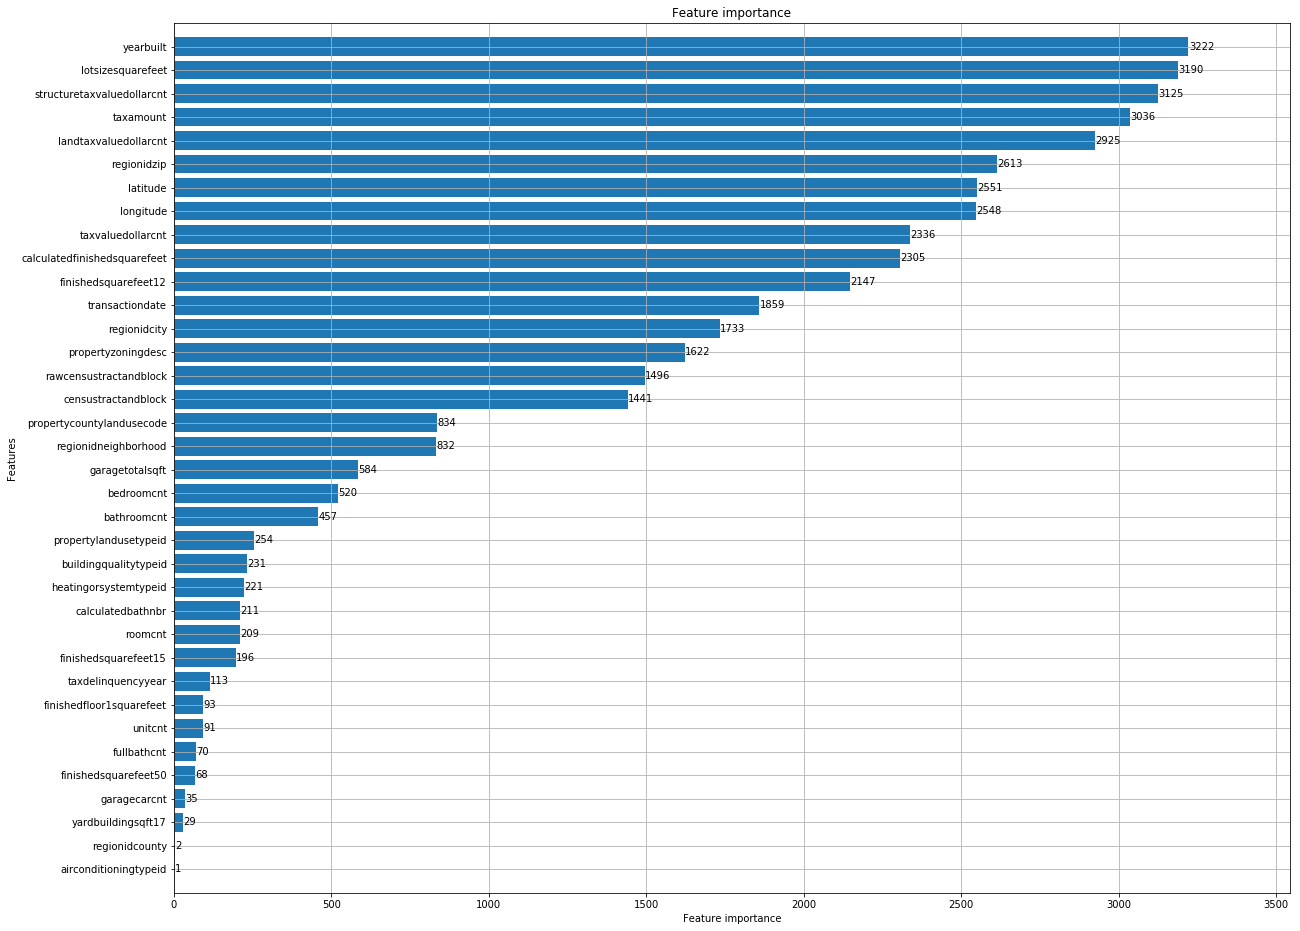

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(20,16))
lgb.plot_importance(gbm0_16,figsize=(20,16),height= 0.8,ax = ax)
plt.show()

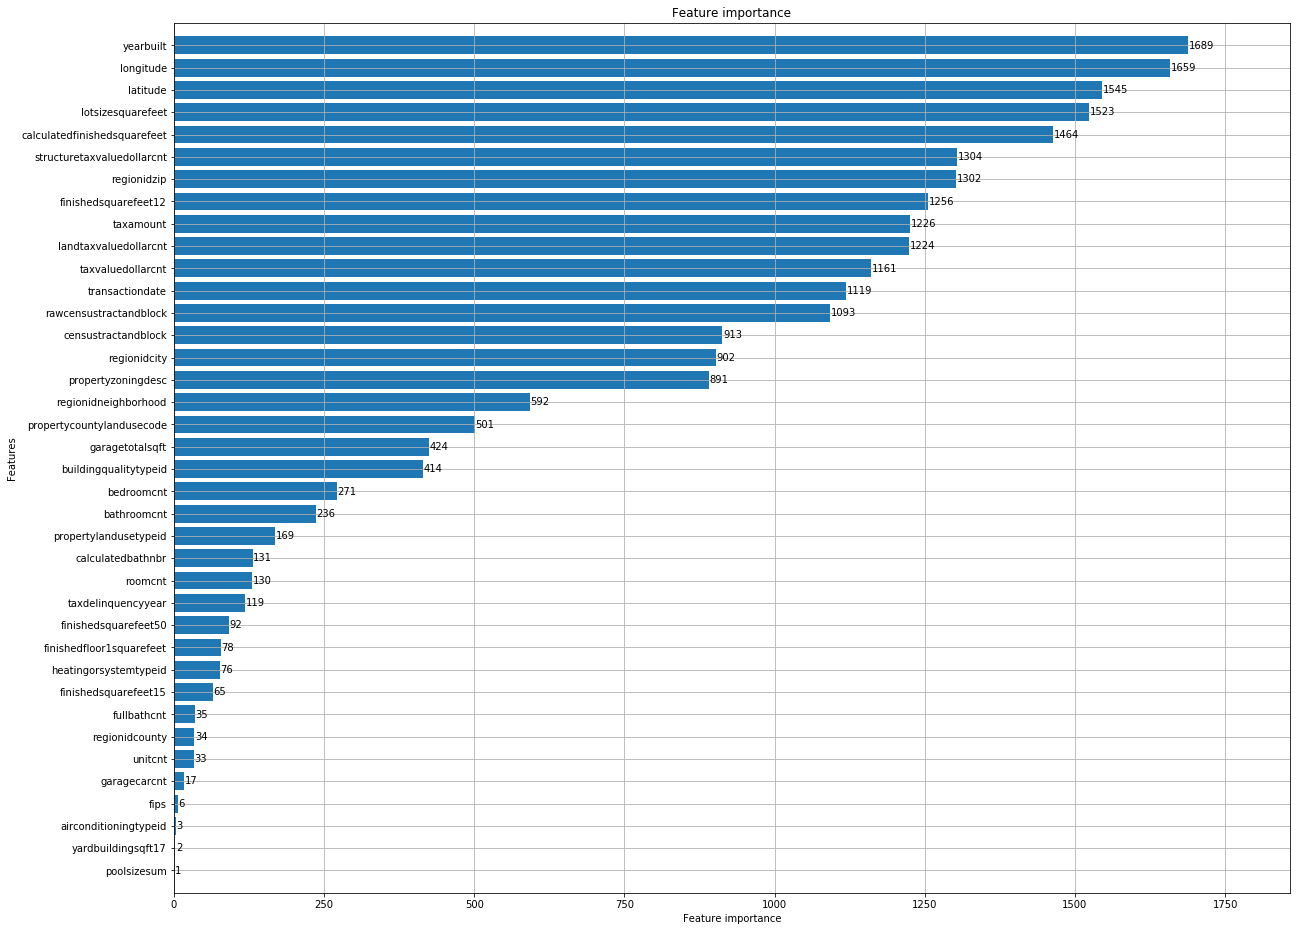

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(20,16))
lgb.plot_importance(gbm0_17,figsize=(20,16),height= 0.8,ax = ax)
plt.show()

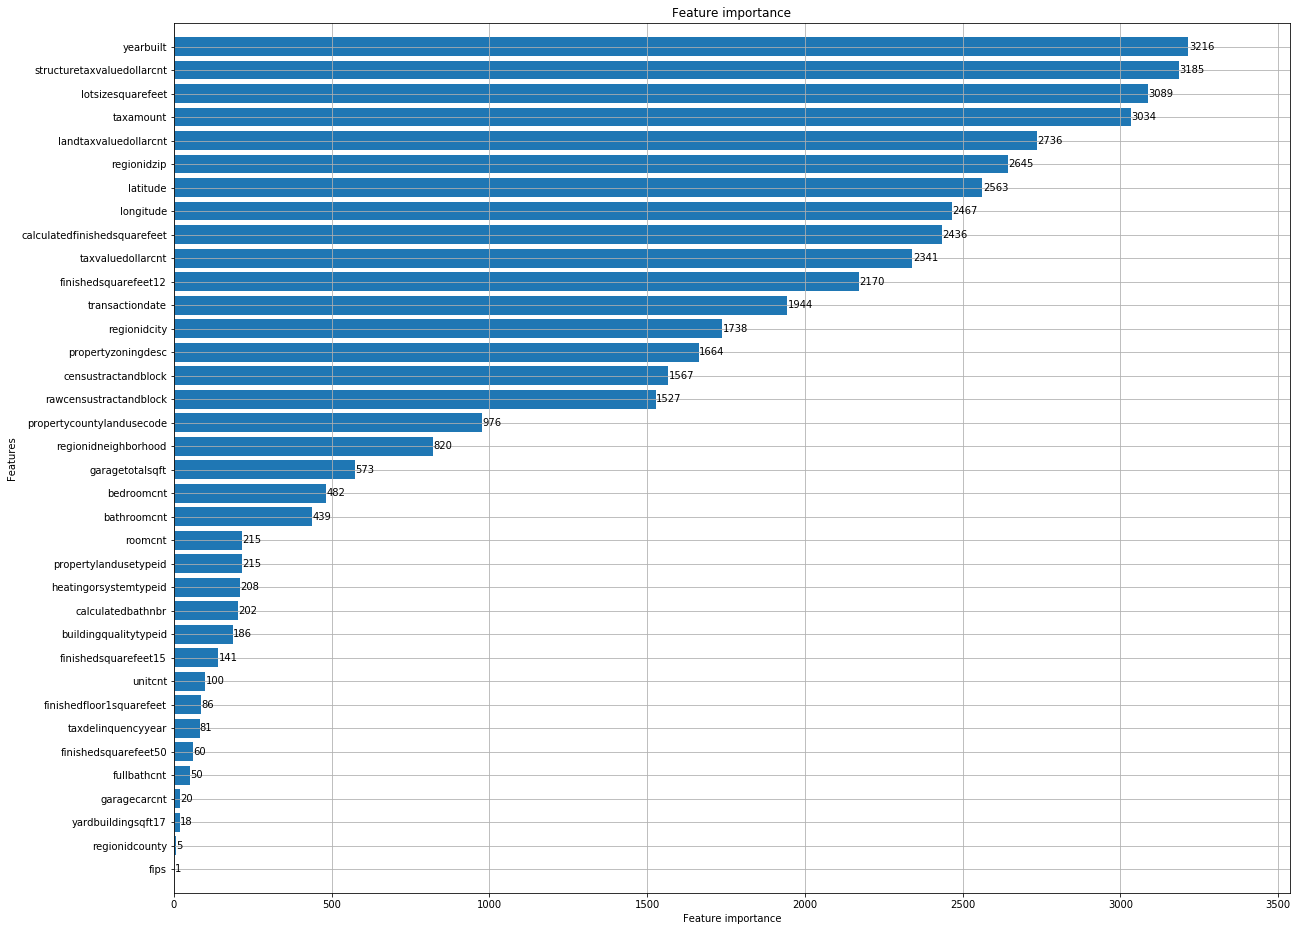

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(20,16))
lgb.plot_importance(gbm1_16,figsize=(20,16),height= 0.8,ax = ax)
plt.show()

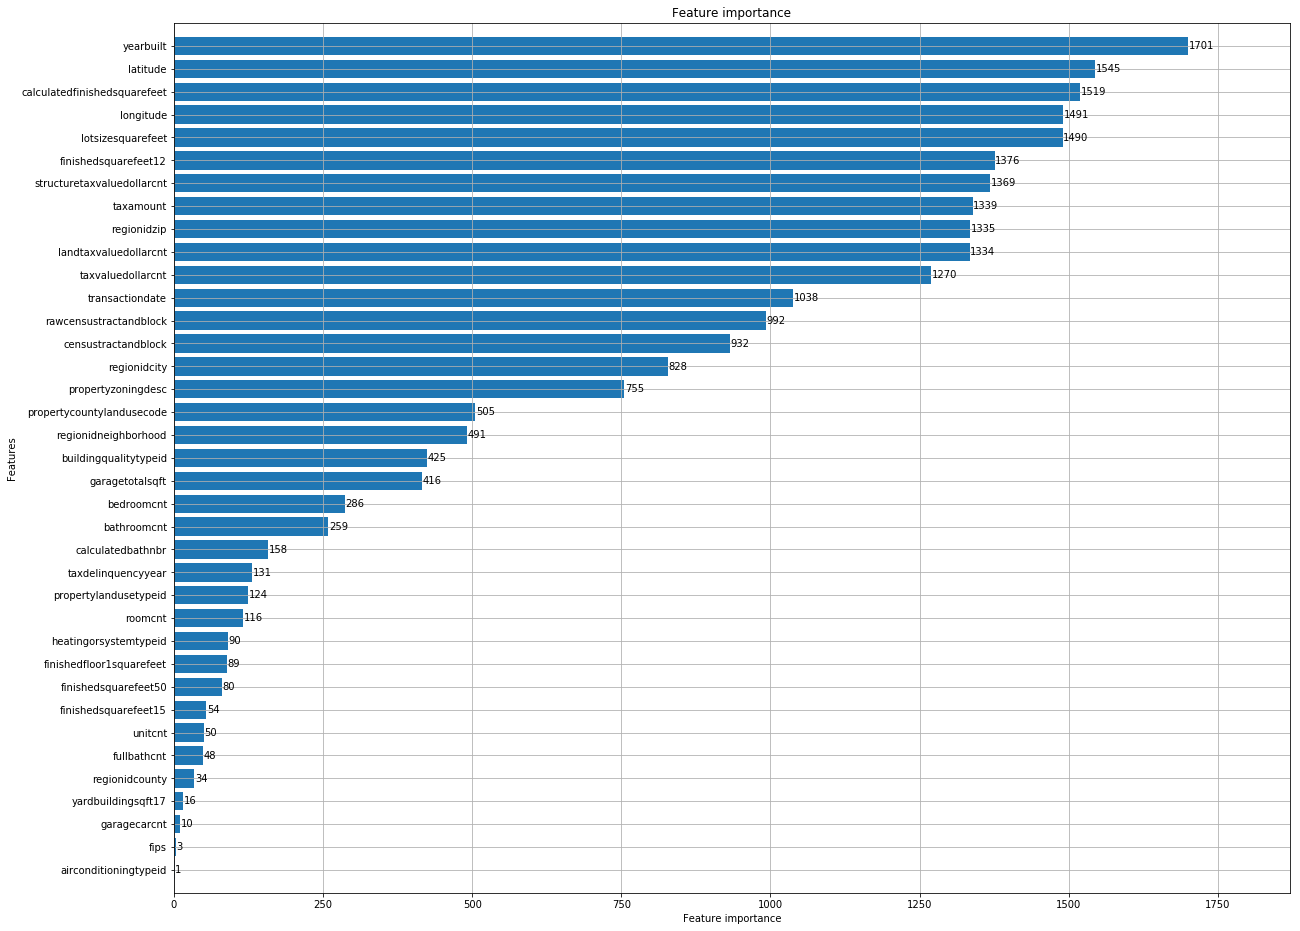

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(20,16))
lgb.plot_importance(gbm1_17,figsize=(20,16),height= 0.8,ax = ax)
plt.show()

### 2016 lightGBM vs Dart

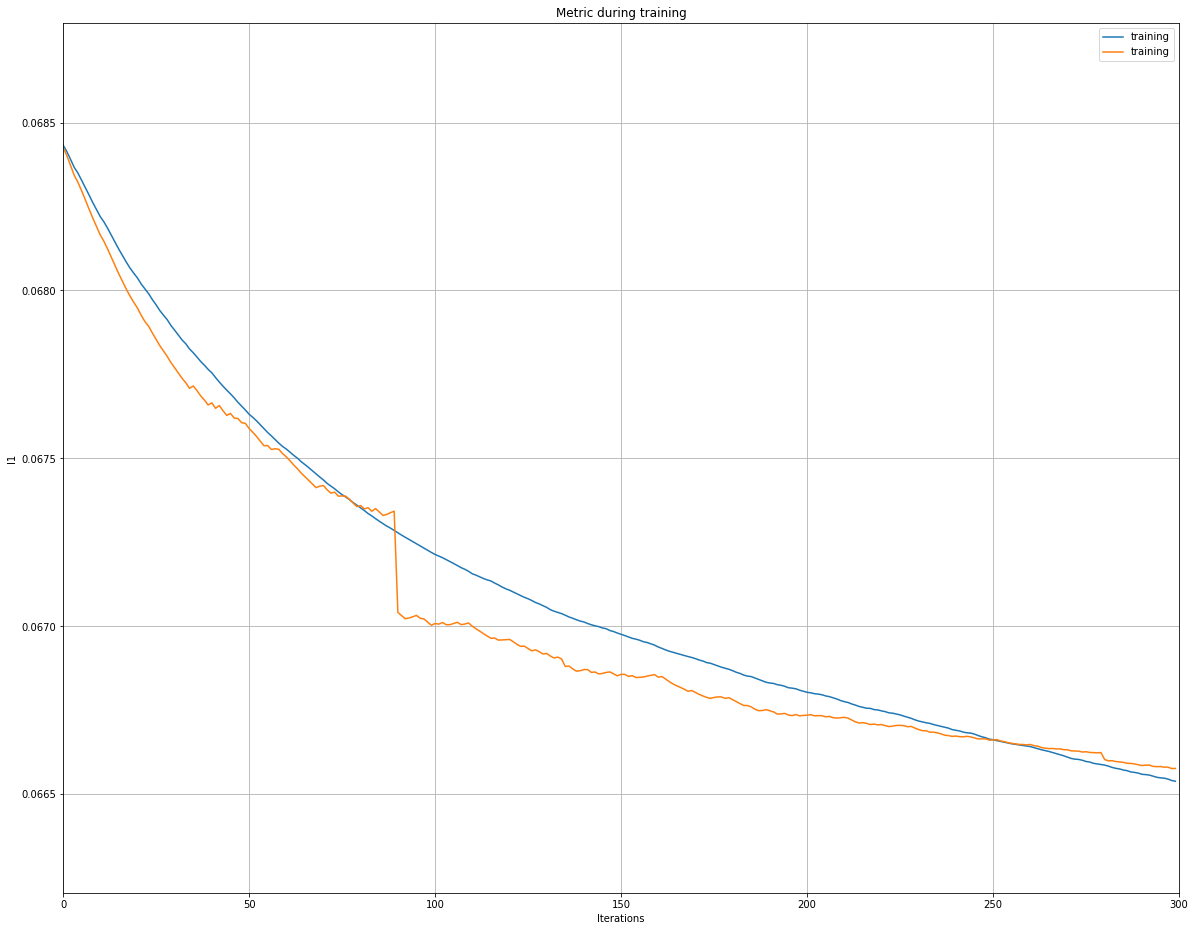

In [34]:
fig, ax = plt.subplots(1,1,figsize=(20,16))
lgb.plot_metric(evals_result0_16,figsize=(10,6),ax = ax)
lgb.plot_metric(evals_result1_16,figsize=(10,6),ax = ax)
plt.show()

### 2017 lightGBM vs Dart

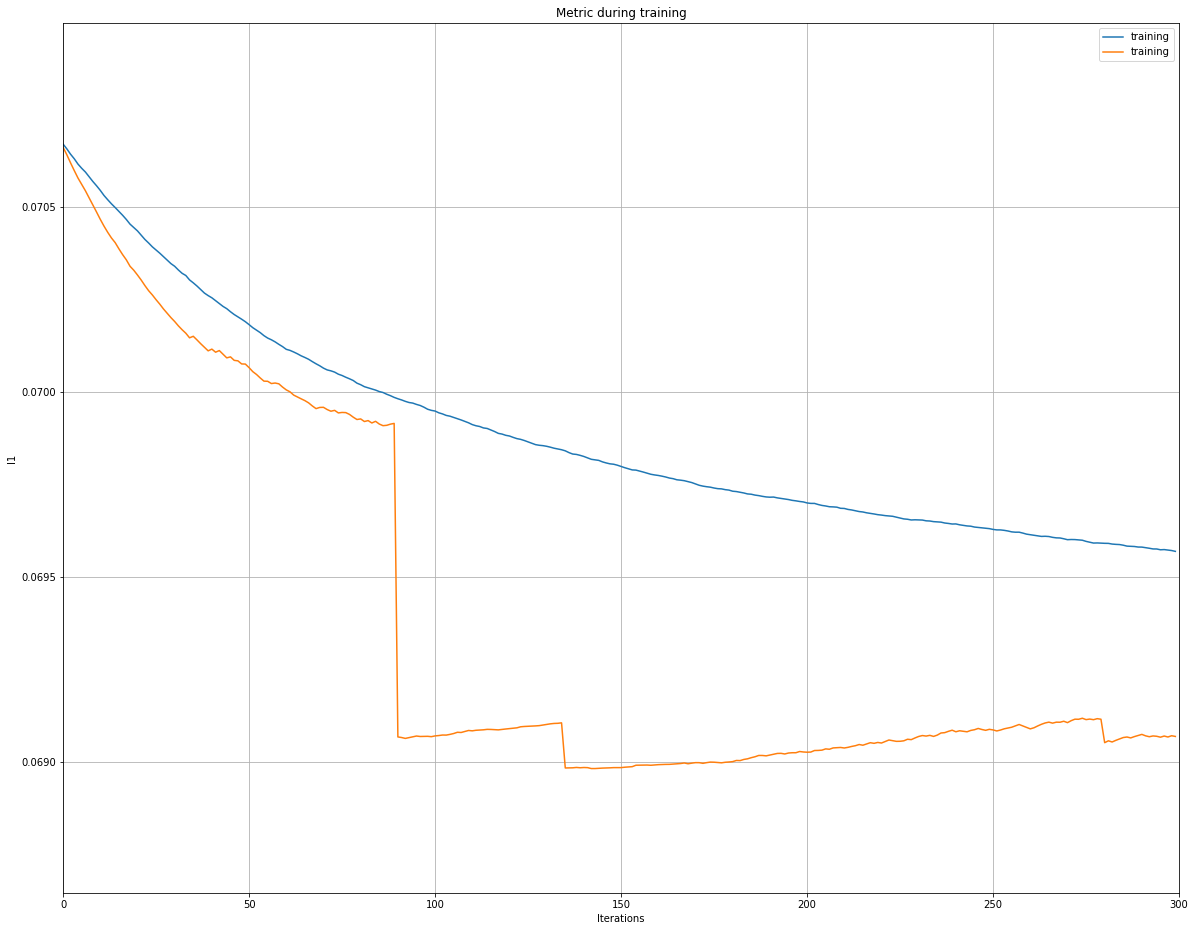

In [35]:
fig, ax = plt.subplots(1,1,figsize=(20,16))
lgb.plot_metric(evals_result0_17,figsize=(10,6),ax = ax)
lgb.plot_metric(evals_result1_17,figsize=(10,6),ax = ax)
plt.show()

### Train and Test on best model

In [90]:
new_X_test10_16 = X_test10_16[train_feature16]
new_X_test11_16 = X_test11_16[train_feature16]
new_X_test12_16 = X_test12_16[train_feature16]
new_X_test10_17 = X_test10_17[train_feature17]
new_X_test11_17 = X_test11_17[train_feature17]
new_X_test12_17 = X_test12_17[train_feature17]

In [ ]:
ransac_X_test10_16 = new_X_test10_16[inlier_mask]
ransac_X_test11_16 = new_X_test11_16[inlier_mask]
ransac_X_test12_16 = new_X_test12_16[inlier_mask]

ransac_X_test10_17 = new_X_test10_17[inlier_mask]
ransac_X_test11_17 = new_X_test11_17[inlier_mask]
ransac_X_test12_17 = new_X_test12_17[inlier_mask]

In [ ]:
clf.fit(new_X_test10_16)
y_pred_inlier10_16 = clf.predict(new_X_test10_16)
clf.fit(new_X_test10_16)
y_pred_inlier11_16 = clf.predict(new_X_test11_16)
clf.fit(new_X_test10_16)
y_pred_inlier12_16 = clf.predict(new_X_test12_16)
clf.fit(new_X_test10_16)
y_pred_inlier10_17 = clf.predict(new_X_test10_17)
clf.fit(new_X_test10_16)
y_pred_inlier11_17 = clf.predict(new_X_test11_17)
clf.fit(new_X_test10_16)
y_pred_inlier12_17 = clf.predict(new_X_test12_17)


iso_X_test10_16 = new_X_test10_16[y_pred_inlier10_16 != -1]
iso_X_test11_16 = new_X_test11_16[y_pred_inlier11_16 != -1]
iso_X_test12_16 = new_X_test12_16[y_pred_inlier12_16 != -1]
iso_X_test10_17 = new_X_test10_17[y_pred_inlier10_17 != -1]
iso_X_test11_17 = new_X_test11_17[y_pred_inlier11_17 != -1]
iso_X_test12_17 = new_X_test12_17[y_pred_inlier12_17 != -1]

In [ ]:
out_X_test10_16 = new_X_test10_16[y_pred_inlier10_16 == -1]
out_X_test11_16 = new_X_test11_16[y_pred_inlier11_16 == -1]
out_X_test12_16 = new_X_test12_16[y_pred_inlier12_16 == -1]
out_X_test10_17 = new_X_test10_17[y_pred_inlier10_17 == -1]
out_X_test11_17 = new_X_test11_17[y_pred_inlier11_17 == -1]
out_X_test12_17 = new_X_test12_17[y_pred_inlier12_17 == -1]

In [96]:
def train_and_test(X_test,estimator):
    
    y_pred = estimator.predict(X_test)
    
    return y_pred

In [ ]:
estimator16 = rangbm16
estimator17 = rangbm17

y_pred10_16 = train_and_test(new_X_test10_16.values,estimator16)
y_pred11_16 = train_and_test(new_X_test11_16.values,estimator16)
y_pred12_16 = train_and_test(new_X_test12_16.values,estimator16)

y_pred10_17 = train_and_test(new_X_test10_17.values,estimator17)
y_pred11_17 = train_and_test(new_X_test11_17.values,estimator17)
y_pred12_17 = train_and_test(new_X_test12_17.values,estimator17)

In [150]:
estimator16 = gbm3_16
estimator17 = gbm3_17

iso_y_pred10_16 = train_and_test(iso_X_test10_16.values,estimator16)
iso_y_pred11_16 = train_and_test(iso_X_test11_16.values,estimator16)
iso_y_pred12_16 = train_and_test(iso_X_test12_16.values,estimator16)

iso_y_pred10_17 = train_and_test(iso_X_test10_17.values,estimator17)
iso_y_pred11_17 = train_and_test(iso_X_test11_17.values,estimator17)
iso_y_pred12_17 = train_and_test(iso_X_test12_17.values,estimator17)

In [ ]:
estimator16 = gbm0_16
estimator17 = gbm0_17

out_y_pred10_16 = train_and_test(out_X_test10_16.values,estimator16)
out_y_pred11_16 = train_and_test(out_X_test11_16.values,estimator16)
out_y_pred12_16 = train_and_test(out_X_test12_16.values,estimator16)

out_y_pred10_17 = train_and_test(out_X_test10_17.values,estimator17)
out_y_pred11_17 = train_and_test(out_X_test11_17.values,estimator17)
out_y_pred12_17 = train_and_test(out_X_test12_17.values,estimator17)

In [151]:
# merged on Parcelid for predicted result on test data

test_dict_16 = {'Parcelid': test_parcelid16, '201610': y_pred10_16, '201611': y_pred11_16, '201612': y_pred12_16}
test_dict_17 = {'Parcelid': test_parcelid17, '201710': y_pred10_17, '201711': y_pred11_17, '201712': y_pred12_17}

df_test_16 = pd.DataFrame(data=test_dict_16)
df_test_17 = pd.DataFrame(data=test_dict_17)

df_merged = df_test_16.merge(df_test_17, left_on='Parcelid', right_on='Parcelid', how='outer')
print(df_merged)

# handle submission file
submitfile = "./zillow data/sample_submission.csv"

submit_df = pd.read_csv(submitfile)
print(submit_df.shape[0], submit_df.shape[1])

assert(submit_df.shape[0] == df_merged.shape[0]), "Error: invalid row size for submit!"
df_merged.to_csv("./zillow data/d_submission3.csv", index=False)

          Parcelid    201610    201611    201612    201710    201711    201712
0         10754147 -0.007666 -0.007813 -0.007498  0.026477  0.026477  0.026477
1         10759547 -0.006645 -0.006645 -0.006243  0.026260  0.026260  0.026260
2         10843547 -0.009059 -0.008995 -0.007450  0.022387  0.022387  0.022387
3         10859147 -0.003355 -0.003069 -0.001724  0.010351  0.010351  0.010351
4         10879947 -0.003911 -0.003911 -0.002118 -0.001485 -0.001485 -0.001485
5         10898347  0.007382  0.007382  0.007382  0.018279  0.018279  0.018279
6         10933547  0.003472  0.003256  0.005205 -0.000748 -0.000748 -0.000748
7         10940747  0.013043  0.013238  0.013720  0.024379  0.024379  0.024379
8         10954547 -0.005466 -0.005612 -0.005516  0.026906  0.026906  0.026906
9         10976347  0.008969  0.008969  0.009228  0.023137  0.023137  0.023137
10        11073947  0.007431  0.007431  0.008051  0.011285  0.011285  0.011285
11        11114347 -0.008225 -0.008371 -0.008549  0.

In [99]:
df_merged.to_csv("./zillow data/d_submission0.csv", index=False)

In [100]:
from sklearn.externals import joblib

joblib.dump(gbm0_16, "./model/gbm0_16 42.m")
joblib.dump(gbm0_17, "./model/gbm0_17 42.m")

['./model/gbm0_17 42.m']

In [ ]:
from sklearn.externals import joblib

joblib.dump(gbm0_16, "./model/gbm0_16 42.m")
joblib.dump(gbm0_17, "./model/gbm0_17 42.m")

In [53]:
from tqdm import tqdm

def ensemble_train_and_test_16(X_train,y_train,X_test):
    
    y_pred = 0
    num_ensembles = 5
    for i in tqdm(range(num_ensembles)):
        bst = lgb.LGBMRegressor(n_jobs = -1, silent = False,
                                boosting_type = 'gbdt' ,
                                learning_rate = 0.011,
                                num_leaves = 145,
                                max_depth = -1,
                                reg_alpha = 0.01,
                                reg_lambda = 100,
                                min_split_gain = 0,
                                min_child_samples = 300,
                                min_child_weight = 0.001,
                                subsample = 0.8,
                                subsample_freq = 1,
                                subsample_for_bin = 50000,
                                n_estimators = 512,
                                random_state = i
                               )
        bst.fit(X_train, y_train)
        y_pred += bst.predict(X_test)
    
    y_pred = y_pred/num_ensembles
    return y_pred

In [54]:
def ensemble_train_and_test_17(X_train,y_train,X_test):
    
    y_pred = 0
    num_ensembles = 5
    for i in tqdm(range(num_ensembles)):
        bst = lgb.LGBMRegressor(n_jobs = -1, silent = False,
                                boosting_type = 'gbdt' ,
                                learning_rate = 0.011,
                                num_leaves = 80,
                                max_depth = -1,
                                reg_alpha = 0.01,
                                reg_lambda = 500,
                                min_split_gain = 0,
                                min_child_samples = 300,
                                min_child_weight = 0.001,
                                subsample = 0.6,
                                subsample_freq = 1,
                                subsample_for_bin = 50000,
                                n_estimators = 512,
                                random_state = i
                               )
        bst.fit(X_train, y_train)
        y_pred += bst.predict(X_test)
    
    y_pred = y_pred/num_ensembles
    return y_pred